In [1]:
# import Libraries
from IPython.core.debugger import set_trace

%load_ext nb_black

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
plt.style.use(style='seaborn')
%matplotlib inline
import datetime as dt
import pandas_datareader as web

<IPython.core.display.Javascript object>

In [2]:
import seaborn as sns

<IPython.core.display.Javascript object>

In [3]:
start = dt.datetime(2014,1,1)
end = dt.datetime(2020,12,30)

crypto_currency = 'BTC'
against_currency = 'USD'

<IPython.core.display.Javascript object>

In [4]:
data = web.DataReader(f'{crypto_currency}-{against_currency}','yahoo', start, end)

<IPython.core.display.Javascript object>

In [5]:
df = data.reset_index()

<IPython.core.display.Javascript object>

In [6]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2014-09-16,468.174011,452.421997,465.864014,457.334015,21056800.0,457.334015
1,2014-09-17,456.859985,413.104004,456.859985,424.440002,34483200.0,424.440002
2,2014-09-18,427.834991,384.532013,424.102997,394.795990,37919700.0,394.795990
3,2014-09-19,423.295990,389.882996,394.673004,408.903992,36863600.0,408.903992
4,2014-09-20,412.425995,393.181000,408.084991,398.821014,26580100.0,398.821014


<IPython.core.display.Javascript object>

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2293 non-null   datetime64[ns]
 1   High       2293 non-null   float64       
 2   Low        2293 non-null   float64       
 3   Open       2293 non-null   float64       
 4   Close      2293 non-null   float64       
 5   Volume     2293 non-null   float64       
 6   Adj Close  2293 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 125.5 KB


<IPython.core.display.Javascript object>

In [8]:
df.isnull().sum()

Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

<IPython.core.display.Javascript object>

In [9]:
df.shape

(2293, 7)

<IPython.core.display.Javascript object>

In [10]:
df = df[['Close']].copy()

<IPython.core.display.Javascript object>

In [11]:
df.describe()

,Close
count,2293.000000
mean,4914.940651
std,4806.605529
min,178.102997
25%,444.669006
50%,3892.350098
75%,8374.686523
max,28840.953125


<IPython.core.display.Javascript object>

Stationary
Subtract the previous from the current values. Now if just difference once, we might not get a stationary series so might need to do that multiple times.
And the minimum number of differencing operations needs to make the series stationary needs to be imputed into ARIMA model

ADF test
I'll use the Augumented Dickey Fuller(ADF) test to check if the price series is stationary.
The null hypothesis of the ADF test is that the time series is non-stationary. So if the p-value of the test is less than the significance level (0.05) then can reject the null hypothesis and infer that the time series is indeed stationary.
So in this case if the p-value > 0.05 i'll need to find the order of differencing.

In [25]:
# Check if price series is stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.Close.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: 1.4617399827422226
p-value: 0.9973773367020442


<IPython.core.display.Javascript object>

Autocorrelation Function (ACF)

In [26]:
from statsmodels.graphics.tsaplots import plot_acf

<IPython.core.display.Javascript object>

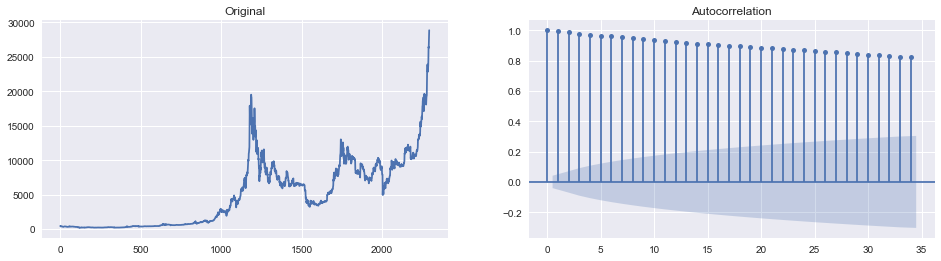

<IPython.core.display.Javascript object>

In [28]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))

ax1.plot(df.Close)
ax1.set_title("Original")
# add ; at the end of the plot function so that the plot is not duplicated
plot_acf(df.Close, ax = ax2);

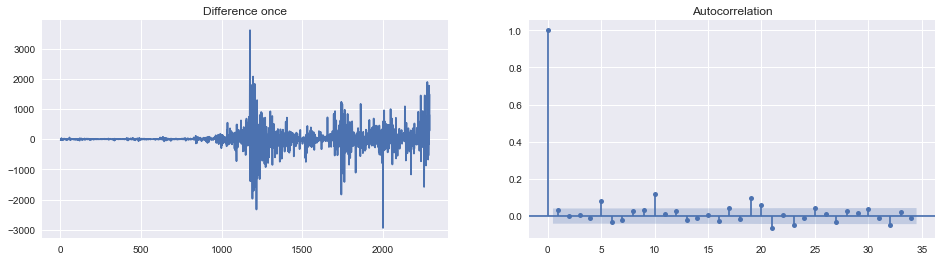

<IPython.core.display.Javascript object>

In [34]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Difference once")
plot_acf(diff, ax = ax2);

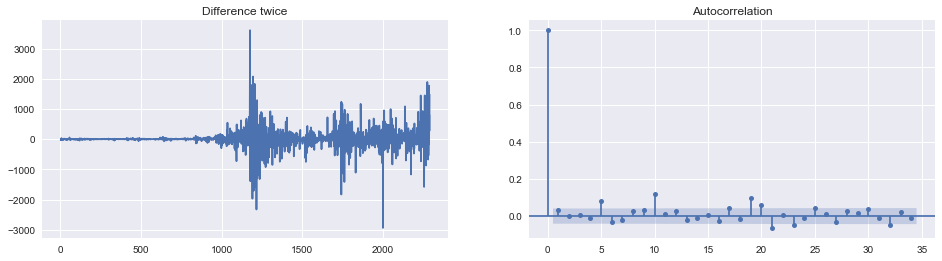

<IPython.core.display.Javascript object>

In [36]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Difference twice")
plot_acf(diff, ax = ax2);

In [37]:
from pmdarima.arima.utils import ndiffs

<IPython.core.display.Javascript object>

In [38]:
ndiffs(df.Close, test="adf")

1

<IPython.core.display.Javascript object>

In [39]:
from statsmodels.graphics.tsaplots import plot_pacf

<IPython.core.display.Javascript object>

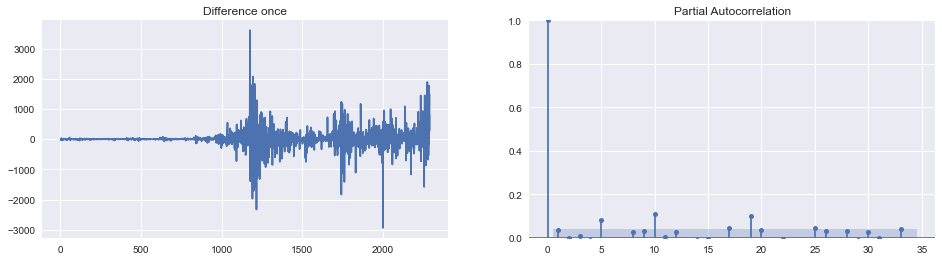

<IPython.core.display.Javascript object>

In [41]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0,1)
plot_pacf(diff,ax=ax2);

Can observe that the PACF lag 5,10,17,19,25 is significant as it's above the significance line

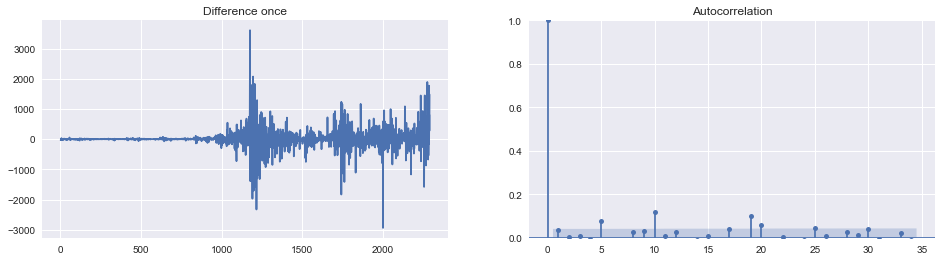

<IPython.core.display.Javascript object>

In [43]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0,1)
plot_acf(diff, ax=ax2);

Train test split

In [12]:
n = int(len(df) * 0.8)
train = df.Close[:n]
test = df.Close[n:]

<IPython.core.display.Javascript object>

In [13]:
print(len(train))
print(len(test))

1834
459


<IPython.core.display.Javascript object>

In [14]:
from statsmodels.tsa.arima_model import ARIMA

<IPython.core.display.Javascript object>

In [48]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


<IPython.core.display.Javascript object>

In [64]:
model = ARIMA(train, order=(4,1,3))
result = model.fit(disp=0)

/home/code-error/.local/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<IPython.core.display.Javascript object>

In [65]:
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1833
Model:                 ARIMA(4, 1, 3)   Log Likelihood              -12917.062
Method:                       css-mle   S.D. of innovations            278.088
Date:                Thu, 26 Aug 2021   AIC                          25852.123
Time:                        15:53:41   BIC                          25901.747
Sample:                             1   HQIC                         25870.424
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.4526      6.386      0.697      0.486      -8.063      16.968
ar.L1.D.Close    -0.2592      0.079     -3.274      0.001      -0.414      -0.104
ar.L2.D.Close    -0.6410      0.053    -

<IPython.core.display.Javascript object>

(array([3.81653499e-06, 1.24037387e-05, 4.00736174e-05, 1.41307208e-03,
        2.45212373e-04, 2.67157449e-05, 5.72480249e-06, 9.54133748e-07,
        0.00000000e+00, 9.54133748e-07]),
 array([-2207.49474607, -1635.71564464, -1063.93654321,  -492.15744178,
           79.62165965,   651.40076108,  1223.17986251,  1794.95896394,
         2366.73806537,  2938.5171668 ,  3510.29626823]),
 <BarContainer object of 10 artists>)

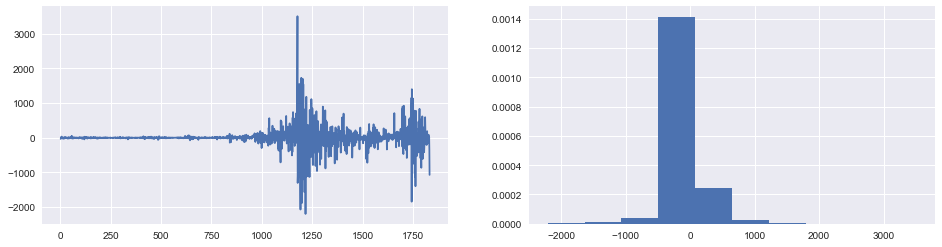

<IPython.core.display.Javascript object>

In [67]:
residuals = pd.DataFrame(result.resid)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))

ax1.plot(residuals)
ax2.hist(residuals, density=True)

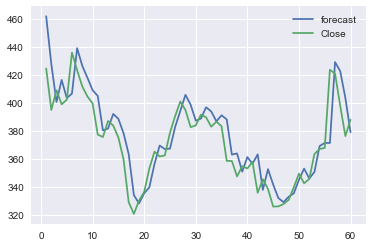

<IPython.core.display.Javascript object>

In [68]:
result.plot_predict(
    start = 1,
    end = 60,
    dynamic = False
);

In [78]:
step = 60
fc, se, conf = result.forecast(step)

<IPython.core.display.Javascript object>

In [79]:
conf

array([[ 8037.86277502,  9127.94806535],
       [ 7868.1911155 ,  9440.42111914],
       [ 7743.33934756,  9643.0452137 ],
       [ 7638.160737  ,  9819.72847774],
       [ 7451.99869708,  9864.96722376],
       [ 7312.70899202,  9957.3034323 ],
       [ 7240.13232624, 10102.25626253],
       [ 7205.3231025 , 10266.9576729 ],
       [ 7109.76426387, 10345.62558347],
       [ 6974.68404594, 10377.10517585],
       [ 6874.48672221, 10444.33215901],
       [ 6843.93326148, 10578.94081959],
       [ 6813.67577238, 10700.11329945],
       [ 6724.85188238, 10750.27360678],
       [ 6608.76134016, 10770.58931199],
       [ 6541.27088817, 10842.73368909],
       [ 6526.09966141, 10964.28107245],
       [ 6493.68325402, 11058.47793148],
       [ 6404.58220031, 11088.32119722],
       [ 6307.27568129, 11110.42916171],
       [ 6262.60496382, 11187.85989093],
       [ 6254.11463748, 11298.0429189 ],
       [ 6214.62322163, 11369.13404648],
       [ 6127.01900948, 11387.68026487],
       [ 6047.36

<IPython.core.display.Javascript object>

In [80]:

fc = pd.Series(fc,index=test[:step].index)
lower = pd.Series(conf[:,0], index=test[:step].index)
upper = pd.Series(conf[:,1], index=test[:step].index)

<IPython.core.display.Javascript object>

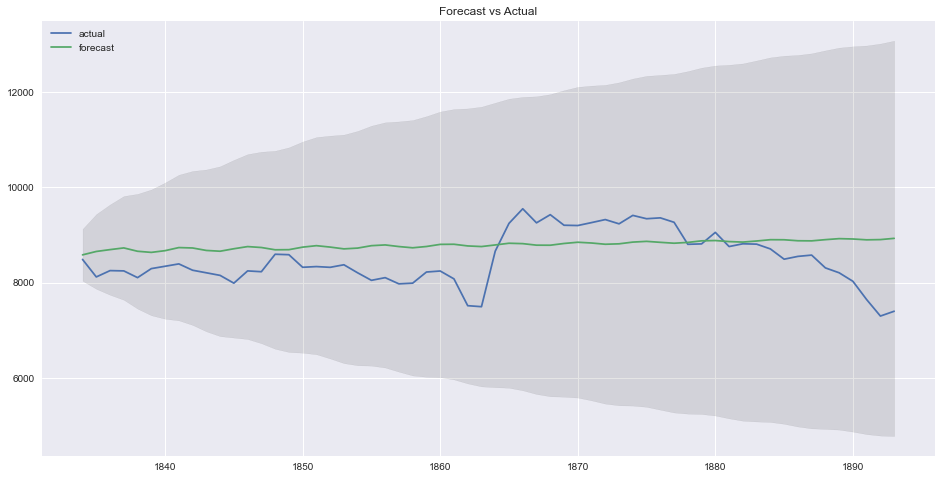

<IPython.core.display.Javascript object>

In [81]:
plt.figure(figsize=(16,8))
plt.plot(test[:step], label='actual')
plt.plot(fc,label='forecast')
plt.fill_between(lower.index, lower, upper, color='k', alpha=0.1)
plt.title("Forecast vs Actual")
plt.legend(loc='upper left')